# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
import warnings
import pickle
import csv
import time
import re

warnings.filterwarnings('ignore')
np.random.seed(42)

%matplotlib inline

# 2. Load the Clean Data

In [2]:
train = pd.read_csv('../datasets/train_clean.csv',index_col='Id')

In [3]:
train.shape

(2048, 54)

The dimension of the training dataset is (2048,71). 

# 3. Feature engineering

### Engineering the new feature `Total_Bath` which accounts for all bathrooms in the house.

In [4]:
train['Total_Bath'] = train['Full Bath'] + 0.5 * train['Half Bath']+ train['Bsmt Full Bath']

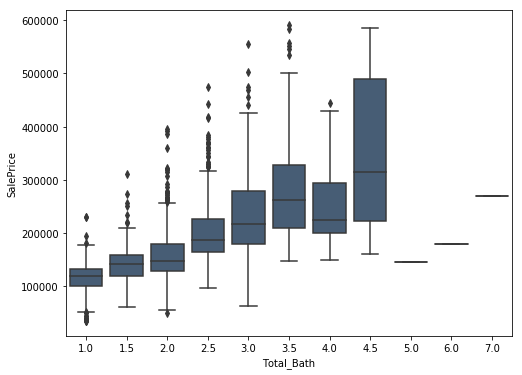

In [5]:
plt.figure(figsize=(8,6))
sns.boxplot(train['Total_Bath'],train['SalePrice'], color = "#3F5D7D");

Fair linear relationship can be observed between `SalePrice` and new feature `Total_Bath`. Drop the less insignificant variables `Full Bath`, `Half Bath`, `Bsmt Full Bath`, and `Bsmt Half Bath`.

### Engineering the new feature `Total_Sqft` which accounts for total square foot of the house

In [6]:
train["Total_Sqft"] = train["Gr Liv Area"] + train["Total Bsmt SF"]

### Log transform of the features `Lot Area` and `Lot Frontage`

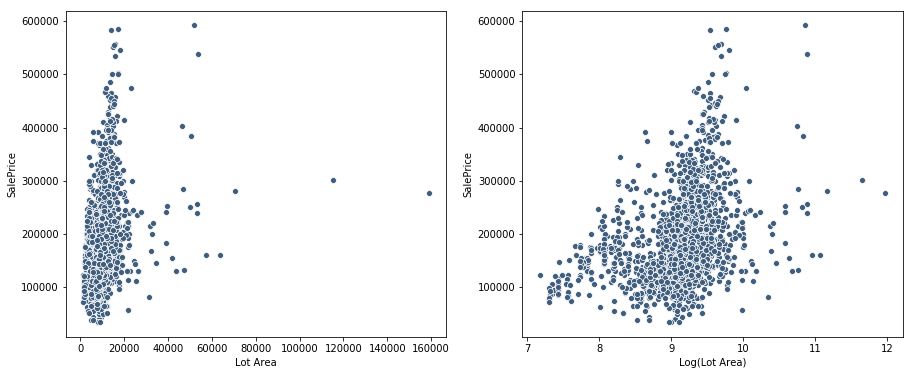

In [7]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15,6))
sns.scatterplot(train['Lot Area'],train['SalePrice'], color = "#3F5D7D", ax=ax[0]);
sns.scatterplot(np.log(train['Lot Area']),train['SalePrice'], color = "#3F5D7D", ax=ax[1]);
ax[1].set_xlabel('Log(Lot Area)');

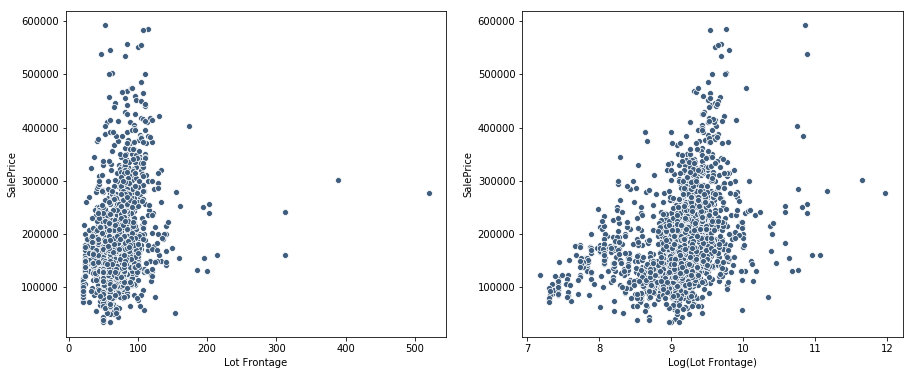

In [8]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15,6))
sns.scatterplot(train['Lot Frontage'],train['SalePrice'], color = "#3F5D7D", ax=ax[0]);
sns.scatterplot(np.log(train['Lot Area']),train['SalePrice'], color = "#3F5D7D", ax=ax[1]);
ax[1].set_xlabel('Log(Lot Frontage)');

The linear relationship with `SalePrice` increased after log transformed `Lot Area` and `Lot Frontage`.

In [9]:
train['Lot Area'] = np.log(train['Lot Area'])
train['Lot Frontage'] = np.log(train['Lot Area'])

### There are some categorical features can be converted into ordered numbers when the information shows the ordered relationship. For example, when the categorical feature contain  'po', 'Fa', 'Ex', they can be encoded as 1, 2, 3. 

In [10]:
train = train.replace({"Bsmt Cond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Bsmt Qual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "Exter Cond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "Exter Qual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "Firep laceQu" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Garage Cond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Garage Qual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Heating QC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Kitchen Qual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Garage Finish" : {"None" : 0, "Unf" : 1, "RFn" : 2, "Fin" : 3}})

# 4. Polynomial feature of top 4 important features

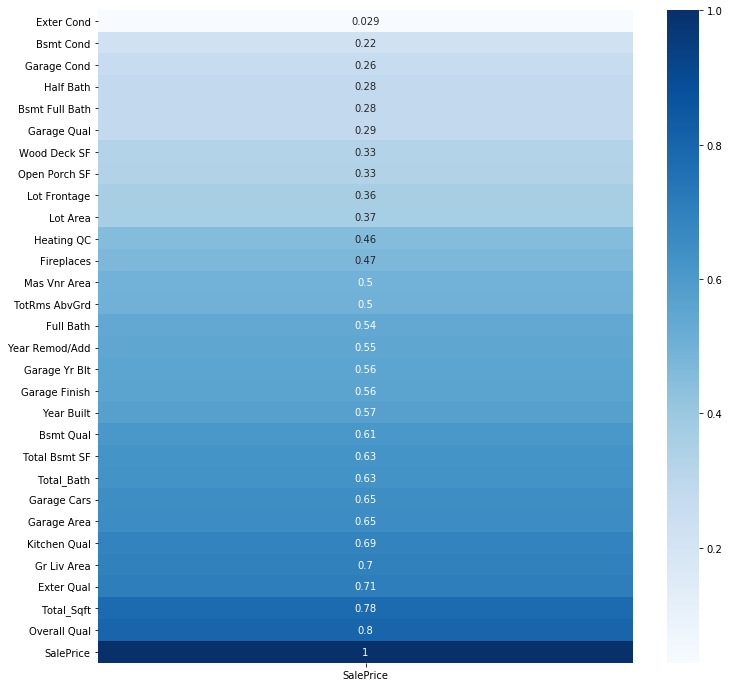

In [11]:
plt.figure(figsize = (12,12))
sns.heatmap(train.corr()[['SalePrice']].sort_values('SalePrice'), annot=True,cmap ='Blues');

In [12]:
Feature = train[['Overall Qual','Total_Sqft','Gr Liv Area','Exter Qual']]
poly = PolynomialFeatures()
Feature_poly = poly.fit_transform(Feature)
poly_col_names = poly.get_feature_names(['Overall Qual','Total_Sqft','Gr Liv Area','Exter Qual'])
X_TopFea_Poly = pd.DataFrame(Feature_poly, columns=poly_col_names, index=train.index).iloc[:,5:]

In [13]:
train = pd.concat([train,X_TopFea_Poly],axis=1)

# 5. One-hot encoding

In [14]:
train_dummies = pd.get_dummies(train)

It should be noted that when the categorical variable includes only two values, `get_dummies` function will generate two perfectly negatively correlated binary outputs. Let's look at the columns of `Central Air_N` and `Central Air_Y`.

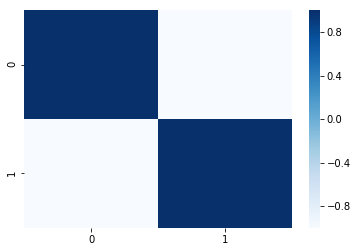

In [15]:
sns.heatmap(np.corrcoef(train_dummies['Central Air_N'],train_dummies['Central Air_Y']),cmap = 'Blues');

The column `Central Air_N` can be dropped in this case.

In [16]:
train_dummies.drop('Central Air_N',1,inplace=True)

In [17]:
train_dummies.columns

Index(['Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Heating QC',
       'Kitchen Qual', 'Garage Finish', 'Garage Qual', 'Garage Cond',
       'Lot Frontage',
       ...
       'Paved Drive_Y', 'Sale Type_COD', 'Sale Type_CWD', 'Sale Type_Con',
       'Sale Type_ConLD', 'Sale Type_ConLI', 'Sale Type_ConLw',
       'Sale Type_New', 'Sale Type_Oth', 'Sale Type_WD '],
      dtype='object', length=230)

# 6. Set up `X` and `y`

In [18]:
X = train_dummies.drop('SalePrice', 1)
y = train_dummies['SalePrice']

# 7. Create training and validation sets

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    random_state = 42)

In [20]:
print('shape of the X_train:', X_train.shape, 'shape of the X_test:', X_test.shape)

shape of the X_train: (1536, 229) shape of the X_test: (512, 229)


# 8. Export the data and scaler for use in future notebooks

In [21]:
X_train.to_csv('../datasets/X_train.csv', index=False, header=False)
X_test.to_csv('../datasets/X_test.csv', index=False, header=False)
y_train.to_csv('../datasets/y_train.csv', index=False, header=False)
y_test.to_csv('../datasets/y_test.csv',index=False, header=False)

Pickle the column names.

In [22]:
with open('../assets/columns.pkl', 'wb+') as f:
    pickle.dump(X_train.columns, f)